In [64]:
pip install wordcloud lazypredict

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for lazypredict from https://files.pythonhosted.org/packages/bb/df/936639581c018ac59b1096d34e42d39e967d97bf09b1fdb1645e64852e36/lazypredict-0.2.12-py2.py3-none-any.whl.metadata
  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/e1/4c/4685ccfae9806f561de716e32549190c1f533dde5bcadaf83bdf23972cf0/lightgbm-4.3.0-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   --------------------- ------------------ 163.8/300.2 kB 5.0 MB/s eta 0:00:01
   ----------

In [67]:
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve#, plot_precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
#from lazypredict.Supervised import LazyClassifier, LazyRegressor
import pickle
import time

# dataset 1

In [43]:
data1 = pd.read_csv('twitter_parsed_dataset.csv')

print('data with NULL values')
print(data1.isnull().sum())
print(data1.describe())
data1.head()

data with NULL values
index         0
id            1
Text          1
Annotation    3
oh_label      3
dtype: int64
           oh_label
count  16848.000000
mean       0.317367
std        0.465465
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [44]:
data1 = pd.DataFrame(data1[['id','oh_label','Text']])
# Before renaming the columns
print("\nBefore modifying column names:\n", data1.columns)

data1.rename(columns = {'oh_label':'label','Text':'tweet'}, inplace = True)
  
# After renaming the columns
print("\nAfter modifying first column:\n", data1.columns)


Before modifying column names:
 Index(['id', 'oh_label', 'Text'], dtype='object')

After modifying first column:
 Index(['id', 'label', 'tweet'], dtype='object')


In [46]:
data1 = data1.dropna(axis=0,how='any')

print(data1.isnull().sum())
print(data1.describe())
data1.head()

id       0
label    0
tweet    0
dtype: int64
              label
count  16848.000000
mean       0.317367
std        0.465465
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


,id,label,tweet
0,5.74948705591165E+017,0.0,@halalflaws @biebervalue @greenlinerzjm I read...
1,5.71917888690393E+017,0.0,@ShreyaBafna3 Now you idiots claim that people...
2,3.90255841338601E+017,1.0,"RT @Mooseoftorment Call me sexist, but when I ..."
3,5.68208850655916E+017,1.0,"@g0ssipsquirrelx Wrong, ISIS follows the examp..."
4,5.75596338802373E+017,0.0,#mkr No No No No No No


# dataset2

In [57]:
data2 = pd.read_csv('toxicity_parsed_dataset.csv')
print('data with NULL values')
print(data2.isnull().sum())
print(data2.describe())
data2.head()

data with NULL values
index         0
Text          0
ed_label_0    0
ed_label_1    0
oh_label      0
dtype: int64
              index     ed_label_0     ed_label_1       oh_label
count  159686.00000  159686.000000  159686.000000  159686.000000
mean    79842.50000       0.854951       0.145049       0.096201
std     46097.52188       0.253866       0.253866       0.294868
min         0.00000       0.000000       0.000000       0.000000
25%     39921.25000       0.800000       0.000000       0.000000
50%     79842.50000       1.000000       0.000000       0.000000
75%    119763.75000       1.000000       0.200000       0.000000
max    159685.00000       1.000000       1.000000       1.000000


,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.9,0.1,0
1,1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0
2,2,Elected or Electoral? JHK,1.0,0.0,0
3,3,`This is such a fun entry. Devotchka I once...,1.0,0.0,0
4,4,Please relate the ozone hole to increases in c...,0.8,0.2,0


In [58]:
data2 = pd.DataFrame(data2[['index','oh_label','Text']])
# Before renaming the columns
print("\nBefore modifying column names:\n", data2.columns)

data2.rename(columns = {'index':'id','oh_label':'label','Text':'tweet'}, inplace = True)
  
# After renaming the columns
print("\nAfter modifying first column:\n", data2.columns)


Before modifying column names:
 Index(['index', 'oh_label', 'Text'], dtype='object')

After modifying first column:
 Index(['id', 'label', 'tweet'], dtype='object')


# merge data

In [52]:
data = pd.concat([data1, data2], ignore_index = True)
data.shape

(176534, 3)

In [53]:
train, test = train_test_split(data, test_size=0.3,random_state=10, shuffle=True)
train['label'].value_counts()

label
0.0    109075
1.0     14498
Name: count, dtype: int64

In [59]:
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]


In [60]:
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

label
1.0    109075
0.0    109075
Name: count, dtype: int64

In [61]:
train_upsampled

,id,label,tweet
77947,61099,1.0,spot grow up the article is being improved ...
13254,5.64178493366231E+017,1.0,excuse me did you say that feminism is for e...
153094,136246,1.0,reerere kevin forsyth hates blacks kevin ...
14788,5.75135746782196E+017,1.0,haq because they use their women as baby mach...
77583,60735,1.0,1 1st u said my edit summary was blankwrong no...
...,...,...,...
9372,5.64767169775284E+017,0.0,gg averaged lt200 oc tweetshr in the past 24 hrs
105595,88747,0.0,the talk page may need protection there is a...
93553,76705,0.0,deleting my talk page plethora of emails an...
94735,77887,0.0,this talk is useless title canot be changed w...


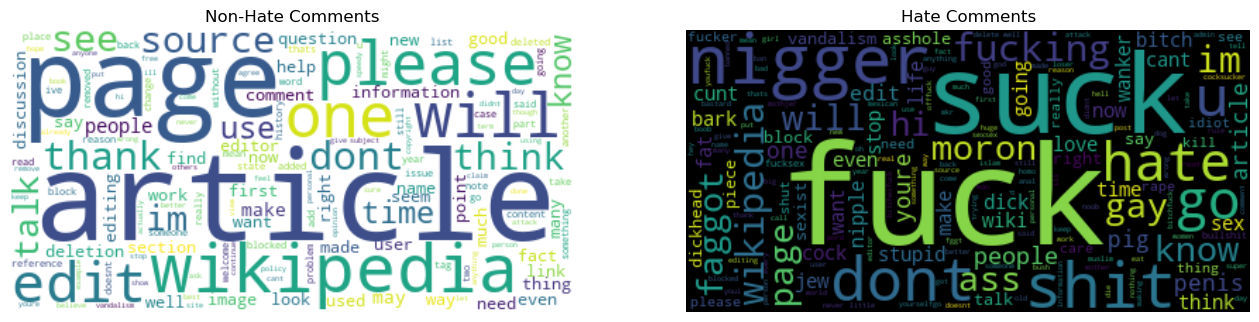

In [68]:
fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['tweet'][train.label == 0])
text_neg = " ".join(train_clean['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

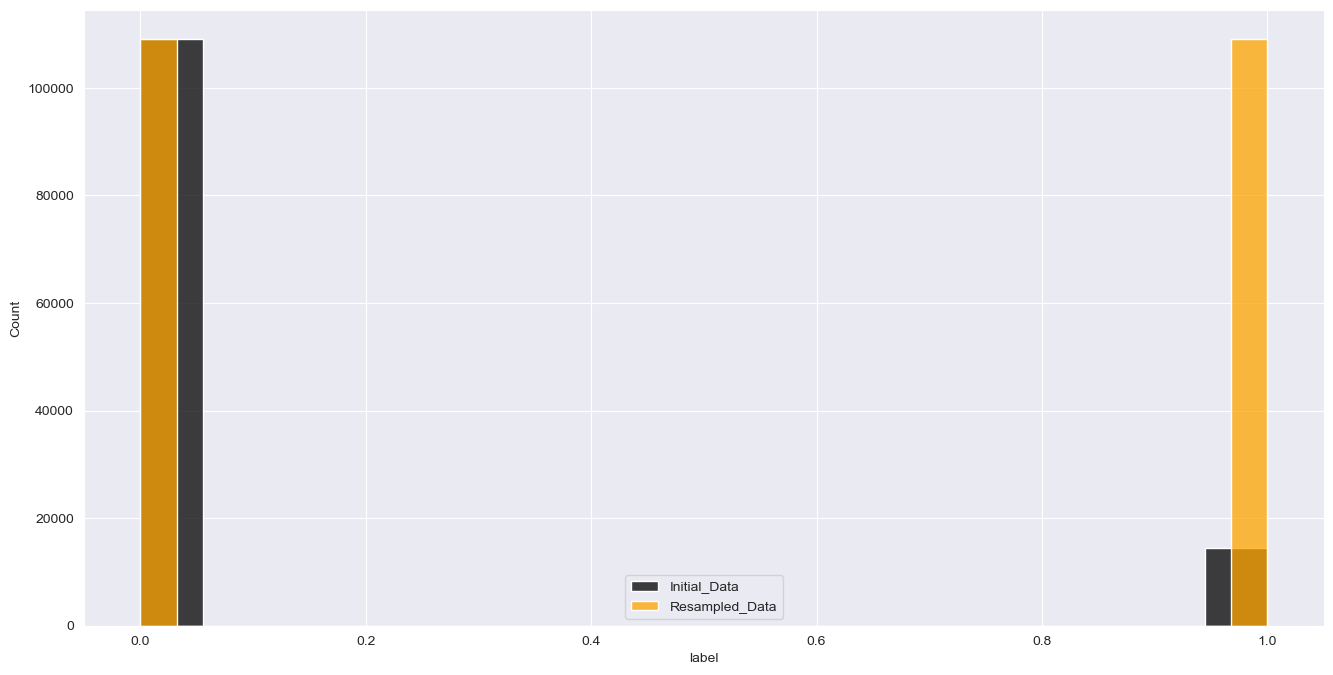

In [69]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

--------------After Upsampling the Minority Class---------------


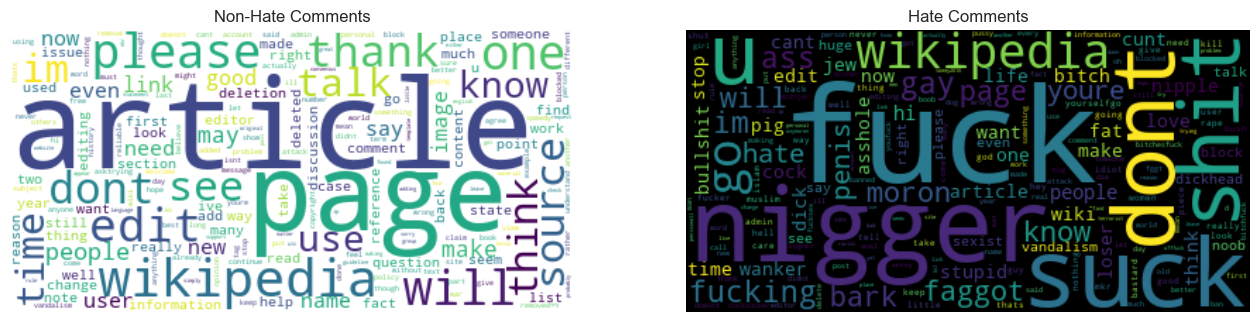

In [70]:
print('--------------After Upsampling the Minority Class---------------')

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_upsampled['tweet'][train.label == 0])
text_neg = " ".join(train_upsampled['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [47]:
train1, test1 = train_test_split(data1, test_size=0.3,random_state=10, shuffle=True)
print("Training Set 1 :"% train1.columns, train1.shape)
#test1 = pd.read_csv('test_tweets_anuFYb8.csv')
print("Test Set 1 :"% test1.columns, test1.shape)

print('Train Set 1 -----')
print(train1.isnull().sum())
print('Test Set 1 -----')
print(test1.isnull().sum())
train1.head()

Training Set 1 : (11793, 3)
Test Set 1 : (5055, 3)
Train Set 1 -----
id       0
label    0
tweet    0
dtype: int64
Test Set 1 -----
id       0
label    0
tweet    0
dtype: int64


,id,label,tweet
4088,5.75298581550105E+017,1.0,@loveconcursall @ottomanland ...the Prophet Mo...
4159,4.76403219841561E+017,0.0,RT @BeRh00M: @YesYoureSexist there are limitat...
64,5.63383421787861E+017,0.0,My favorite part of this trip has to be all th...
11343,5.54046468193919E+017,0.0,@archnerdian @jokereplica @KarlreMarks They sh...
3290,5.72348812909421E+017,0.0,I wouldn't order anything on Katie and Nikki's...
